In [7]:
%env LD_LIBRARY_PATH= / home / zach / anaconda3 / envs / research / lib

env: LD_LIBRARY_PATH=/ home / zach / anaconda3 / envs / research / lib


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
import re
import codecs
from tqdm import tqdm

In [9]:
## Data Import and Cleaning
train = pd.read_csv('data/hateval2019_en_train.csv')
test = pd.read_csv('data/hateval2019_en_test.csv')
val = pd.read_csv('data/hateval2019_en_dev.csv')

train = train.drop(['TR', 'AG'], 1)
test = test.drop(['TR', 'AG'], 1)
val = val.drop(['TR', 'AG'], 1)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


/tmp/ipykernel_502511/962749627.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train = train.drop(['TR', 'AG'], 1)
/tmp/ipykernel_502511/962749627.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test = test.drop(['TR', 'AG'], 1)
/tmp/ipykernel_502511/962749627.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  val = val.drop(['TR', 'AG'], 1)


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import L1, L2, l1_l2
import io


def normalize_tweet(text):
    """
    Removes hashtags, @s, links, and punctuation
    :param text:Text to be cleaned
    :return: text with mentions, hashtages, and urls removes
    """
    processed_text = text.lower()
    processed_text = re.sub(r"(?:\@|http?\://|https?\://|www|t\.)\S+", "", processed_text)
    processed_text = re.sub(r"(?:\.|,|\?|-)", " ", processed_text)
    processed_text = re.sub(r"(?:\@|http?\://|https?\://|www|\.com)", "", processed_text)
    processed_text = re.sub(r'[^\w\s]', '', processed_text)
    processed_text = " ".join(processed_text.split())
    return processed_text


def x_y_split(data):
    """splits and X and y from dataframe

    Args:
        data:dataframe to split from

    Returns:
        tuple:X data, y data
    """
    X = data['text']
    X = X.apply(normalize_tweet)
    y = data['HS']
    return X, y


In [11]:
## Split sequences into train, validation, and test sets
#Split x and ys
x_train, y_train = x_y_split(train)
print(x_train)
#x_train.to_csv('data/x_train.csv')
#y_train.to_csv('data/y_train.csv')
#Split x and ys
x_test, y_test = x_y_split(test)
print(x_test)
#x_test.to_csv('data/x_test.csv')
#y_test.to_csv('data/y_test.csv')
#Split x and ys
x_val, y_val = x_y_split(val)
print(x_val)
#x_val.to_csv('data/x_val.csv')
#y_val.to_csv('data/y_val.csv')
## Tokenizer
max_features = 15000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(x_train)


def tokenize_and_pad(x_data, tokenizer=tokenizer, length=57):
    """
    Tokenizes and pads input
    :param x_data: X column of data
    :param tokenizer: fitted tokenizer
    :param length: length to pad
    :return: tokenized and padded x_data
    """
    x_data = tokenizer.texts_to_sequences(x_data)
    x_data = pad_sequences(x_data, maxlen=length)
    return x_data


x_train = tokenize_and_pad(x_train, tokenizer)


def split_and_tokenize(data, tokenizer=tokenizer):
    """
    Splits tokenizes and pads data
    :param data:
    :return: tupple of (X,y)
    """
    X, y = x_y_split(data)
    X = tokenize_and_pad(X)
    return X, y


x_val, y_val = split_and_tokenize(val)
x_test, y_test = split_and_tokenize(test)
word_index = tokenizer.word_index
print("Number of unique words:", len(word_index))
word_index

0       hurray saving us in so many ways lockthemup bu...
1       why would young fighting age men be the vast m...
2       illegals dump their kids at the border like ro...
3       ny times nearly all white states pose an array...
4       orban in brussels european leaders are ignorin...
                              ...                        
8995                  i am proud to be a hysterical woman
8996    hollywood is complicit in the rape and sexual ...
8997    what a fucking cunt i hate seeing kids getting...
8998                                hysterical woman like
8999    nearly every woman i know has metoo in their f...
Name: text, Length: 9000, dtype: object
0       oh i could have gone on about taxes since the ...
1       several of the wild fires in california and co...
2       my question is how do you resettle a refugee a...
3       europe youve got a problem we must hurry and b...
4       this is outrageous stopillegalimmigration meri...
                              ..

{'the': 1,
 'to': 2,
 'a': 3,
 'you': 4,
 'and': 5,
 'of': 6,
 'in': 7,
 'is': 8,
 'for': 9,
 'i': 10,
 'are': 11,
 'not': 12,
 'that': 13,
 'on': 14,
 'bitch': 15,
 'this': 16,
 'it': 17,
 'all': 18,
 'your': 19,
 'they': 20,
 'be': 21,
 'with': 22,
 'refugees': 23,
 'have': 24,
 'women': 25,
 'we': 26,
 'me': 27,
 'immigrant': 28,
 'from': 29,
 'when': 30,
 'my': 31,
 'like': 32,
 'if': 33,
 'immigration': 34,
 'who': 35,
 'dont': 36,
 'but': 37,
 'their': 38,
 'no': 39,
 'about': 40,
 'so': 41,
 'illegal': 42,
 'as': 43,
 'by': 44,
 'will': 45,
 'up': 46,
 'at': 47,
 'our': 48,
 'just': 49,
 'migrants': 50,
 'do': 51,
 'its': 52,
 'what': 53,
 'or': 54,
 'men': 55,
 'get': 56,
 'people': 57,
 'u': 58,
 'them': 59,
 'her': 60,
 'an': 61,
 'woman': 62,
 'was': 63,
 'can': 64,
 'rape': 65,
 'cunt': 66,
 'how': 67,
 'more': 68,
 'out': 69,
 'go': 70,
 'whore': 71,
 'trump': 72,
 'immigrants': 73,
 'one': 74,
 'us': 75,
 'has': 76,
 'want': 77,
 'fuck': 78,
 'im': 79,
 'youre': 80,
 'why

In [12]:
## Embedding Matrix using Wikipedia Embeddings
#download Wikipedia 2014 embeddings from https://github.com/stanfordnlp/GloVe
#Load GLoVe embeddings; here I use embeddings with only 100 dimensions
embeddings_index = {}
f = codecs.open('data/glove.42B.300d.txt', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

embeddings_index
embed_dim = 300

nb_words = min(max_features, len(tokenizer.word_index))
words_not_found = []
embedding_matrix = np.zeros((nb_words, embed_dim))
word_index = tokenizer.word_index
for word, i in tqdm(word_index.items()):
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

1917495it [01:28, 21716.56it/s]


found 1917495 word vectors


100%|██████████| 17392/17392 [00:00<00:00, 666124.88it/s]

number of null word embeddings: 2456


In [13]:

x_graph_train = pd.read_csv('data/extracted_annotations_train.csv')


x_graph_val = pd.read_csv('data/extracted_annotations_val.csv')


x_graph_test = pd.read_csv('data/extracted_annotations_test.csv')


In [14]:
x_graph_train = x_graph_train['annotations']
x_graph_val = x_graph_val['annotations']
x_graph_test = x_graph_test['annotations']


In [15]:
x_graph_train = x_graph_train.apply(str)
x_graph_val = x_graph_val.apply(str)
x_graph_test = x_graph_test.apply(str)

In [16]:
max_features_graph = 15000
graph_tokenizer = Tokenizer(num_words=max_features_graph,split=' ', lower=True)

In [17]:
graph_tokenizer.fit_on_texts(x_graph_train)
max_graph_length = 2254

In [18]:
x_graph_train = tokenize_and_pad(x_graph_train,graph_tokenizer,max_graph_length)
x_graph_val = tokenize_and_pad(x_graph_val,graph_tokenizer,max_graph_length)
x_graph_test = tokenize_and_pad(x_graph_test,graph_tokenizer,max_graph_length)



In [19]:
def get_embedding_matrix(tokenizer=graph_tokenizer,max_features=max_features_graph):
    embeddings_index = {}
    f = codecs.open('data/glove.42B.300d.txt', encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('found %s word vectors' % len(embeddings_index))

    embeddings_index
    embed_dim = 300

    nb_words = min(max_features, len(tokenizer.word_index))
    words_not_found = []
    embedding_matrix = np.zeros((nb_words, embed_dim))
    word_index = tokenizer.word_index
    for word, i in tqdm(word_index.items()):
        if i >= nb_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if (embedding_vector is not None) and len(embedding_vector) > 0:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            words_not_found.append(word)
    print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
    return embedding_matrix

In [20]:
graph_embbeding_matrix = get_embedding_matrix()

1917495it [01:29, 21417.10it/s]


found 1917495 word vectors


100%|██████████| 62807/62807 [00:00<00:00, 1763370.29it/s]


number of null word embeddings: 238


In [21]:
max_length = 57

In [22]:
x_graph_train

array([[    0,     0,     0, ..., 12249,     5,     1],
       [    0,     0,     0, ...,     4,    82,   575],
       [    0,     0,     0, ...,  3266,  1589,   117],
       ...,
       [    0,     0,     0, ...,  1362,     8,  2784],
       [    0,     0,     0, ...,    88,    49,   389],
       [    0,     0,     0, ...,     1,    34,    33]], dtype=int32)

In [23]:
import keras_tuner as kt
import tensorflow_addons as tfa
f1 = tfa.metrics.F1Score(num_classes=1, average=None)


class MyHyperModel(kt.HyperModel):
    def __init__(self,embedding_matrix=embedding_matrix,max_features=max_features,embed_dim=embed_dim,input_length=max_length,max_graph_length=max_graph_length, max_features_graph=max_features_graph,graph_embbeding_matrix=graph_embbeding_matrix):
        self.embedding_matrix= embedding_matrix
        self.max_features = max_features
        self.embed_dim = embed_dim
        self.input_length = input_length
        self.max_graph_length = max_graph_length
        self.max_features_graph =max_features_graph
        self.graph_embbeding_matrix = graph_embbeding_matrix

    def build(self, hp):
        lr = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")
        dropoutLSTM_Graph = hp.Float('dropoutLSTM_Graph',min_value=0,max_value=1)
        dropoutLSTM = hp.Float('dropoutLSTM',min_value=0,max_value=1)
        dropout1 = hp.Float('dropout1',min_value=0,max_value=1)
        wd = hp.Choice('wd', [0.0,0.01,0.001,0.1,0.005,0.05,.00001,.0001])
        lstm_size = hp.Choice('lstm_size', [128,256,512,1024])
        lstm_size_graph = hp.Choice('lstm_size_graph', [128,256,512,1024])
        dense_size = hp.Choice('dense_size', [128,256,512,1024])

        optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
        input_graph = Input(shape=(max_graph_length,))
        embbeding_graph =  Embedding(max_features_graph,embed_dim,input_length=max_graph_length, weights=[graph_embbeding_matrix],trainable=False)(input_graph)
        lstm_graph = LSTM(lstm_size_graph,dropout=dropoutLSTM_Graph)(embbeding_graph)
        graph_model = Model(inputs=input_graph,outputs=lstm_graph)


        input_x = Input(shape=(max_length,))
        embedding = Embedding(max_features,embed_dim,input_length=max_length, weights=[embedding_matrix],trainable=False)(input_x)
        lstm = LSTM(lstm_size,dropout=dropoutLSTM)(embedding)
        normal_model = Model(inputs=input_x,outputs=lstm)

        combined = concatenate([normal_model.output,graph_model.output])

        x = Dense(dense_size,activation='relu')(combined)
        x = Dropout(dropout1)(x)
        x = Dense(dense_size,activation='relu')(x)
        x = Dense(1,activation='sigmoid')(x)

        model = Model(inputs=[normal_model.input,graph_model.input],outputs=x)
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
        return model
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32,16]),
            epochs = 20,
            verbose = 2,
            **kwargs,
        )
from kerastuner.tuners import RandomSearch

tuner = kt.RandomSearch(
    MyHyperModel(),
    objective= kt.Objective('val_accuracy',direction='max'),
    max_trials = 100,
    directory="checkpoints",
    project_name="GloVe_Graph_search",
)

INFO:tensorflow:Reloading Oracle from existing project checkpoints/GloVe_Graph_search/oracle.json


2022-06-03 19:52:08.265168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-03 19:52:08.266167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 19:52:08.266557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 19:52:08.266869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

INFO:tensorflow:Reloading Tuner from checkpoints/GloVe_Graph_search/tuner0.json


In [24]:
tuner.search(x=[x_train,x_graph_train],
             y=y_train,
             validation_data=([x_val,x_graph_val],y_val))

INFO:tensorflow:Oracle triggered exit


In [25]:
model = tuner.get_best_models()[0]

In [26]:
from sklearn.metrics import classification_report
pred = model.predict([x_train,x_graph_train])
pred = np.round(pred)
#print(pred)
print(classification_report(y_train,pred))

2022-06-03 19:52:10.588020: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 81144000 exceeds 10% of free system memory.
2022-06-03 19:52:11.291750: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


282/282 [==============================] - 13s 44ms/step
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      5217
           1       0.79      0.82      0.80      3783

    accuracy                           0.83      9000
   macro avg       0.83      0.83      0.83      9000
weighted avg       0.83      0.83      0.83      9000



In [27]:
pred = model.predict([x_val,x_graph_val])
pred = np.round(pred)
#print(pred)
print(classification_report(y_val,pred))

32/32 [==============================] - 1s 41ms/step
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       573
           1       0.72      0.70      0.71       427

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000



In [28]:
pred = model.predict([x_test,x_graph_test])
pred = np.round(pred)
#print(pred)
print(classification_report(y_test,pred))

94/94 [==============================] - 4s 44ms/step
              precision    recall  f1-score   support

           0       0.74      0.17      0.27      1740
           1       0.44      0.92      0.60      1260

    accuracy                           0.48      3000
   macro avg       0.59      0.54      0.44      3000
weighted avg       0.61      0.48      0.41      3000



In [31]:
best_hps=tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)

optimizer = tfa.optimizers.AdamW(learning_rate=best_hps['lr'], weight_decay=best_hps['wd'])

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])


class AdditionalValidationSets(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

callbacks = AdditionalValidationSets([([x_test,x_graph_test],y_test,'test')],verbose=1)


history = model.fit(x=[x_train,x_graph_train],
             y=y_train,
             validation_data=([x_val,x_graph_val],y_val),
                batch_size=32,
                    epochs=20,
                    callbacks=[callbacks])

Epoch 1/20


2022-06-03 19:55:45.208284: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 81144000 exceeds 10% of free system memory.


282/282 [==============================] - 38s 130ms/step - loss: 0.6392 - accuracy: 0.6303 - val_loss: 0.6064 - val_accuracy: 0.6490
Epoch 2/20
282/282 [==============================] - 36s 129ms/step - loss: 0.5876 - accuracy: 0.6908 - val_loss: 0.5970 - val_accuracy: 0.6210
Epoch 3/20
282/282 [==============================] - 37s 130ms/step - loss: 0.5669 - accuracy: 0.7090 - val_loss: 0.5823 - val_accuracy: 0.6700
Epoch 4/20
282/282 [==============================] - 36s 129ms/step - loss: 0.5490 - accuracy: 0.7222 - val_loss: 0.5732 - val_accuracy: 0.6730
Epoch 5/20
282/282 [==============================] - 37s 131ms/step - loss: 0.5352 - accuracy: 0.7361 - val_loss: 0.5566 - val_accuracy: 0.6910
Epoch 6/20
282/282 [==============================] - 36s 128ms/step - loss: 0.5203 - accuracy: 0.7456 - val_loss: 0.5675 - val_accuracy: 0.6840
Epoch 7/20
282/282 [==============================] - 36s 127ms/step - loss: 0.5020 - accuracy: 0.7561 - val_loss: 0.5602 - val_accuracy: 0.6

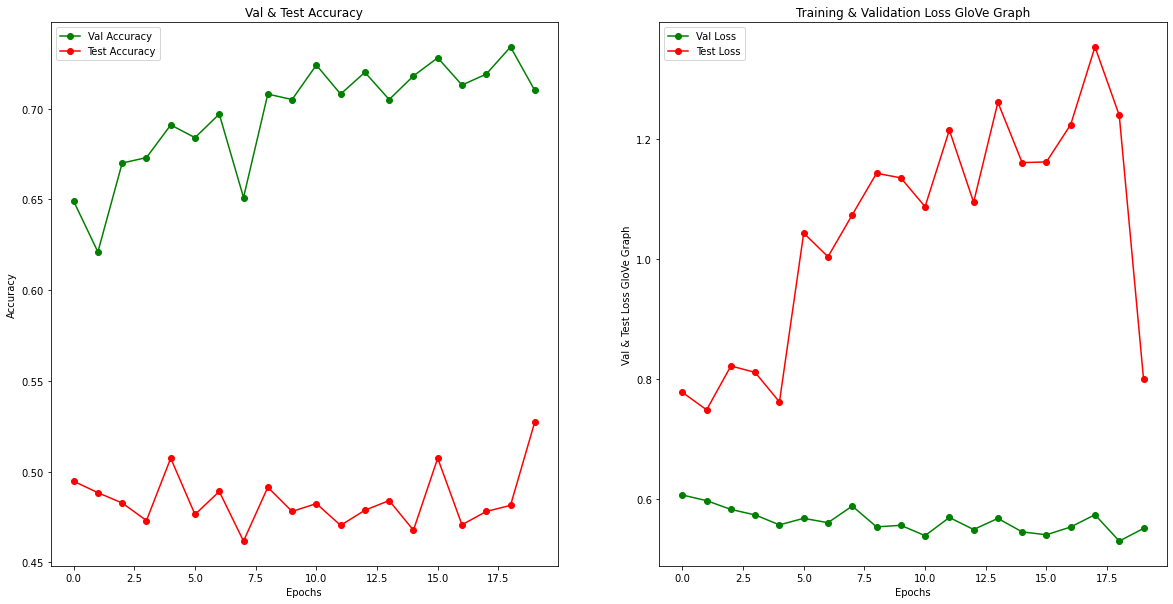

In [32]:
def plot_accuracy_loss_chart_test(history, epoch_count):
    """
    Plots accuracy and losses for each epoch
    :param history: history from fitting model
    :param epoch_count: amount of epochs to plot
    :return: None
    """
    epochs = [i for i in range(epoch_count)]
    fig, ax = plt.subplots(1, 2)
    train_acc = history.history['val_accuracy']
    train_loss = history.history['val_loss']
    val_acc = history.history['test_accuracy']
    val_loss = history.history['test_loss']
    fig.set_size_inches(20, 10)
    ax[0].plot(epochs, train_acc, 'go-', label='Val Accuracy')
    ax[0].plot(epochs, val_acc, 'ro-', label='Test Accuracy')
    ax[0].set_title('Val & Test Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs, train_loss, 'g-o', label='Val Loss')
    ax[1].plot(epochs, val_loss, 'r-o', label='Test Loss')
    ax[1].set_title('Training & Validation Loss GloVe Graph')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Val & Test Loss GloVe Graph")
    plt.show()


plot_accuracy_loss_chart_test(callbacks, 20)